In [1]:
import pyspark
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from functools import reduce
from pyspark.sql.functions import col, to_timestamp, when, trim, lower, udf,split, concat_ws, length, expr, corr
from pyspark.sql.functions import dayofmonth, month, year,unix_timestamp
from pyspark.sql.functions import count,isnan, regexp_replace,lit,to_date, greatest,regexp_extract, dayofweek, datediff,coalesce
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import IntegerType, LongType, FloatType, StringType


from pyspark.sql.types import BooleanType
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import Imputer, StringIndexer
from pyspark.ml.stat import Correlation

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression, IsotonicRegression, \
    DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
# To create a spark session

spark = SparkSession.builder \
    .appName("YouTube Influencer Data Analsyis") \
    .config("spark.sql.execution.pythonUDF.arrow.enabled", "true") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

spark

In [3]:
df = spark.read.csv("Youtube_influencer_data.csv", header = True)
df.printSchema()
df.show()

root
 |-- Video Link: string (nullable = true)
 |-- Video Views: string (nullable = true)
 |-- Video Title: string (nullable = true)
 |-- Channel URL: string (nullable = true)
 |-- Creator Name: string (nullable = true)
 |-- Creator Gender: string (nullable = true)
 |-- Total Channel Subcribers: string (nullable = true)
 |-- Total Chanel Views: string (nullable = true)
 |-- Duration of Video: string (nullable = true)
 |-- Duration in Seconds: string (nullable = true)
 |-- Date of Video Upload: string (nullable = true)
 |-- No of Likes: string (nullable = true)
 |-- Language of the Video: string (nullable = true)
 |-- Subtitle: string (nullable = true)
 |-- Video Description: string (nullable = true)
 |-- Hashtags: string (nullable = true)
 |-- No of Comments: string (nullable = true)
 |-- Date of the Last Comment: string (nullable = true)
 |-- Maximum Quality of the Video: string (nullable = true)
 |-- No of Videos the Channel: string (nullable = true)
 |-- No of Playlist: string (null

In [4]:
# To display the data of dataframe in chunks as the dataset has too many features

# To define the no of features to display in each chunk
features_per_chunk = 3

# To split the features into chunks
columns = df.columns
feature_chunks = [columns[i:i+features_per_chunk] for i in range(0, len(columns), features_per_chunk)]

# Display problematic rows in chunks of columns
for chunk in feature_chunks:
    df.select(chunk).show(truncate=False)

+-------------------------------------------------+-----------+----------------------------------------------------------------------------------+
|Video Link                                       |Video Views|Video Title                                                                       |
+-------------------------------------------------+-----------+----------------------------------------------------------------------------------+
|https://www.youtube.com/watch?v=_0fUOJ55gis      |146,059    |Samse - Didupe Off-road Royal Enfield Himalayan                                   |
|https://www.youtube.com/watch?v=_70MSLPRfZI      |231,969    |Bhoom Baddhal Web Series                                                          |
|https://www.youtube.com/watch?v=_8gfCdt3H00&t=87s|878        |Customer Psychology, Four Views Of Consumer Decision Making                       |
|https://www.youtube.com/watch?v=_CkFNJgKsFs      |9,965      |Top countries with proven natural gas reserves         

+---------------------+--------+-----------------+
|Language of the Video|Subtitle|Video Description|
+---------------------+--------+-----------------+
|Kannada              |No      |Yes              |
|Telugu               |No      |Yes              |
|Hindi                |No      |Yes              |
|English              |No      |Yes              |
|English              |yes     |Yes              |
|Kannada              |No      |Yes              |
|English              |No      |Yes              |
|English              |Yes     |Yes              |
|English              |No      |Yes              |
|Hindi                |yes     |Yes              |
|English              |Yes     |Yes              |
|English              |yes     |Yes              |
|Hindi                |Yes     |Yes              |
|English              |Yes     |Yes              |
|Japenese             |No      |Yes              |
|Telugu               |No      |Yes              |
|English              |Yes     

In [5]:
# To create a copy of the dataframe before preprocessing to retain raw data

df_copy = df.alias("df_copy")


In [6]:
# To rename the column names as it has spaces
modified_column_names = [old_column_name.replace(" ", "_") for old_column_name in df.columns]
df = df.toDF(*modified_column_names)
df.printSchema()

root
 |-- Video_Link: string (nullable = true)
 |-- Video_Views: string (nullable = true)
 |-- Video_Title: string (nullable = true)
 |-- Channel_URL: string (nullable = true)
 |-- Creator_Name: string (nullable = true)
 |-- Creator_Gender: string (nullable = true)
 |-- Total_Channel_Subcribers: string (nullable = true)
 |-- Total_Chanel_Views: string (nullable = true)
 |-- Duration_of_Video: string (nullable = true)
 |-- Duration_in_Seconds: string (nullable = true)
 |-- Date_of_Video_Upload: string (nullable = true)
 |-- No_of_Likes: string (nullable = true)
 |-- Language_of_the_Video: string (nullable = true)
 |-- Subtitle: string (nullable = true)
 |-- Video_Description: string (nullable = true)
 |-- Hashtags: string (nullable = true)
 |-- No_of_Comments: string (nullable = true)
 |-- Date_of_the_Last_Comment: string (nullable = true)
 |-- Maximum_Quality_of_the_Video: string (nullable = true)
 |-- No_of_Videos_the_Channel: string (nullable = true)
 |-- No_of_Playlist: string (null

In [7]:
# To check the missing values in each column

missing_values = [df.columns[i:i+5] for i in range(0, len(df.columns), 5)]

for cols in missing_values:
    missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in cols])
    missing_counts.show()

+----------+-----------+-----------+-----------+------------+
|Video_Link|Video_Views|Video_Title|Channel_URL|Creator_Name|
+----------+-----------+-----------+-----------+------------+
|         0|          0|          0|          0|          11|
+----------+-----------+-----------+-----------+------------+

+--------------+------------------------+------------------+-----------------+-------------------+
|Creator_Gender|Total_Channel_Subcribers|Total_Chanel_Views|Duration_of_Video|Duration_in_Seconds|
+--------------+------------------------+------------------+-----------------+-------------------+
|             6|                       0|                 0|                0|                  0|
+--------------+------------------------+------------------+-----------------+-------------------+

+--------------------+-----------+---------------------+--------+-----------------+
|Date_of_Video_Upload|No_of_Likes|Language_of_the_Video|Subtitle|Video_Description|
+--------------------+---

In [8]:
# To handle the missing Creator_Gender values by analyzing the corresponding Channel_URL and Creator_NAme

missing_rows = df.filter((col("Creator_Gender").isNull()) | (col("Creator_Gender") < 0))
missing_rows.select("Channel_URL", "Creator_Name").show(truncate=False)



+--------------------------------------------------------+----------------------------+
|Channel_URL                                             |Creator_Name                |
+--------------------------------------------------------+----------------------------+
|https://www.youtube.com/c/OfficialTriumph               |Official Triumph Motorcycles|
|https://www.youtube.com/c/VolgaVideo                    |Volga Video                 |
|https://www.youtube.com/c/Thequint                      |The Quint                   |
|https://www.youtube.com/channel/UC0_708wMGk6oaJsiPShujNg|Wild Tusker Sakrebylu       |
|https://www.youtube.com/c/FreeDocumentary               |Free Documentary            |
|https://www.youtube.com/etvtelugu                       |etvteluguindia              |
+--------------------------------------------------------+----------------------------+



In [9]:
def clean_data(df):
    
    # To Standardize Yes/No values in specific columns as the dataset has values in both cases.
    boolean_columns = ['Video_Description', 'Subtitle', 'Premiered_or_Not']
    for column in boolean_columns:
        df = df.withColumn(column, lower(col(column)))

    # To Clean numeric columns with commas, spaces, and special characters
    numeric_columns = ['Video_Views', 'Total_Channel_Subcribers', 'Total_Chanel_Views', 'Duration_in_Seconds','No_of_Comments']
    for column in numeric_columns:
        df = df.withColumn(column, regexp_replace(col(column), '[\s,]', ''))   
   
    # To Replace NA values in Date_Of_Last_Comment column
    df = df.withColumn('Date_of_the_Last_Comment', when((col('Date_of_the_Last_Comment').isNull()) | (col('Date_of_the_Last_Comment') == 'N/A'), '01/01/1991').otherwise(col('Date_of_the_Last_Comment')))

    # To  Replace NA/N/A values in Creator_Gender column
    df = df.withColumn('Creator_Gender', 
                   when((col('Creator_Gender').isNull()) | ((col('Creator_Gender')).isin(['N/A', 'NA'])), 'Company')
                   .otherwise(col('Creator_Gender')))
    
    # To Replace missing values in Creator_Name column
    df = df.withColumn('Creator_Name', when(col('Creator_Name').isNull(), 'None').otherwise(col('Creator_Name')))

    # To Replace NA/N/A values in Language column
    df = df.withColumn('Language_of_the_Video', 
                   when((trim(col('Language_of_the_Video')) == 'N/A') | (col('Language_of_the_Video').isNull()), 'None')
                   .otherwise(col('Language_of_the_Video'))) 
    return df


In [10]:

# To clean the data
cleaned_data = clean_data(df)

cleaned_data.show()

+--------------------+-----------+--------------------+--------------------+--------------------+--------------+------------------------+------------------+-----------------+-------------------+--------------------+-----------+---------------------+--------+-----------------+--------+--------------+------------------------+----------------------------+------------------------+--------------+----------------+-------------------------------------+-----------------------------+
|          Video_Link|Video_Views|         Video_Title|         Channel_URL|        Creator_Name|Creator_Gender|Total_Channel_Subcribers|Total_Chanel_Views|Duration_of_Video|Duration_in_Seconds|Date_of_Video_Upload|No_of_Likes|Language_of_the_Video|Subtitle|Video_Description|Hashtags|No_of_Comments|Date_of_the_Last_Comment|Maximum_Quality_of_the_Video|No_of_Videos_the_Channel|No_of_Playlist|Premiered_or_Not|Community_Engagement_(Posts_per_week)|Intern_Who_Collected_the_Data|
+--------------------+-----------+------

In [11]:
def standardize_date(value):
    # To standardize all the date values
    return concat_ws("", lit("0"), value)


def preprocess_date(cleaned_data):
    # Acceptable date formats for further processing to make casting easier
    date_formats = ["MM/dd/yyyy", "dd/MM/yyyy"] 
    date_columns = [] # To store the formatted date values

    cleaned_data = cleaned_data.withColumn("Date_of_Video_Upload_Processed",
                                                 when(col("Date_of_Video_Upload").contains("/"),
                                                      concat_ws("/", 
                                                                when(length(split(col("Date_of_Video_Upload"), "/")[0]) == 1,
                                                                     standardize_date(split(col("Date_of_Video_Upload"), "/")[0]))
                                                                .otherwise(split(col("Date_of_Video_Upload"), "/")[0]),
                                                                when(length(split(col("Date_of_Video_Upload"), "/")[1]) == 1,
                                                                     standardize_date(split(col("Date_of_Video_Upload"), "/")[1]))
                                                                .otherwise(split(col("Date_of_Video_Upload"), "/")[1]),
                                                                split(col("Date_of_Video_Upload"), "/")[2]))
                                                 .when(col("Date_of_Video_Upload").contains("-"),
                                                       concat_ws("/", 
                                                                 when(length(split(col("Date_of_Video_Upload"), "-")[1]) == 1,
                                                                      standardize_date(split(col("Date_of_Video_Upload"), "-")[1]))
                                                                 .otherwise(split(col("Date_of_Video_Upload"), "-")[1]),
                                                                 when(length(split(col("Date_of_Video_Upload"), "-")[0]) == 1,
                                                                      standardize_date(split(col("Date_of_Video_Upload"), "-")[0]))
                                                                 .otherwise(split(col("Date_of_Video_Upload"), "-")[0]),
                                                                 split(col("Date_of_Video_Upload"), "-")[2]))
                                                 .otherwise(col("Date_of_Video_Upload")))


    for format in date_formats: 
        # Type casting Date_of_Video_Upload_Processed to date type
        date_column = to_date(col("Date_of_Video_Upload_Processed"), format)
        date_columns.append(date_column)

    # To select the first non null date values using coalesce
    cleaned_data = cleaned_data.withColumn("Date_of_Video_Upload",
                                                coalesce(*date_columns))
    cleaned_data = cleaned_data.withColumn("Date_of_the_Last_Comment_Processed",
                                                 when(col("Date_of_the_Last_Comment").contains("/"),
                                                      concat_ws("/", 
                                                                when(length(split(col("Date_of_the_Last_Comment"), "/")[0]) == 1,
                                                                     standardize_date(split(col("Date_of_the_Last_Comment"), "/")[0]))
                                                                .otherwise(split(col("Date_of_the_Last_Comment"), "/")[0]),
                                                                when(length(split(col("Date_of_the_Last_Comment"), "/")[1]) == 1,
                                                                     standardize_date(split(col("Date_of_the_Last_Comment"), "/")[1]))
                                                                .otherwise(split(col("Date_of_the_Last_Comment"), "/")[1]),
                                                                split(col("Date_of_the_Last_Comment"), "/")[2]))
                                                 .when(col("Date_of_the_Last_Comment").contains("-"),
                                                       concat_ws("/", 
                                                                 when(length(split(col("Date_of_the_Last_Comment"), "-")[1]) == 1,
                                                                      standardize_date(split(col("Date_of_the_Last_Comment"), "-")[1]))
                                                                 .otherwise(split(col("Date_of_the_Last_Comment"), "-")[1]),
                                                                 when(length(split(col("Date_of_the_Last_Comment"), "-")[0]) == 1,
                                                                      standardize_date(split(col("Date_of_the_Last_Comment"), "-")[0]))
                                                                 .otherwise(split(col("Date_of_the_Last_Comment"), "-")[0]),
                                                                 split(col("Date_of_the_Last_Comment"), "-")[2]))
                                                 .otherwise(col("Date_of_the_Last_Comment")))
    # Type casting Date_of_the_Last_Comment to date type
    cleaned_data = cleaned_data.withColumn("Date_of_the_Last_Comment", 
                                                to_date(col("Date_of_the_Last_Comment_Processed"), "MM/dd/yyyy"))
    return cleaned_data

def typecasting_columns(preprocessed_data):
    # To type cast the numeric columns to integer,long, float based on the values present in those columns
    preprocessed_data = preprocessed_data.withColumn("Video_Views", col("Video_Views").cast(LongType()))
    preprocessed_data = preprocessed_data.withColumn("Total_Channel_Subcribers", col("Total_Channel_Subcribers").cast(LongType()))
    preprocessed_data = preprocessed_data.withColumn("Total_Chanel_Views", col("Total_Chanel_Views").cast(LongType()))
    preprocessed_data = preprocessed_data.withColumn("Duration_in_Seconds", col("Duration_in_Seconds").cast(FloatType()))
    preprocessed_data = preprocessed_data.withColumn("No_of_Likes", col("No_of_Likes").cast(IntegerType()))
    preprocessed_data = preprocessed_data.withColumn("Hashtags", col("Hashtags").cast(IntegerType()))
    preprocessed_data = preprocessed_data.withColumn("No_of_Comments", col("No_of_Comments").cast(IntegerType()))
    preprocessed_data = preprocessed_data.withColumn("Maximum_Quality_of_the_Video", col("Maximum_Quality_of_the_Video").cast(IntegerType()))
    preprocessed_data = preprocessed_data.withColumn("No_of_Videos_the_Channel", col("No_of_Videos_the_Channel").cast(IntegerType()))
    preprocessed_data = preprocessed_data.withColumn("No_of_Playlist", col("No_of_Playlist").cast(IntegerType()))
    preprocessed_data = preprocessed_data.withColumn("Community_Engagement_(Posts_per_week)", col("Community_Engagement_(Posts_per_week)").cast(IntegerType()))

    return preprocessed_data

In [12]:
# Function call to clean, format and typecast date column
preprocessed_data = preprocess_date(cleaned_data)

# Function call to typecast other numeric columns
preprocessed_data = typecasting_columns(preprocessed_data)

# To view the preprocessed dataframe
preprocessed_data.show()

# To print the schema
preprocessed_data.printSchema()

+--------------------+-----------+--------------------+--------------------+--------------------+--------------+------------------------+------------------+-----------------+-------------------+--------------------+-----------+---------------------+--------+-----------------+--------+--------------+------------------------+----------------------------+------------------------+--------------+----------------+-------------------------------------+-----------------------------+------------------------------+----------------------------------+
|          Video_Link|Video_Views|         Video_Title|         Channel_URL|        Creator_Name|Creator_Gender|Total_Channel_Subcribers|Total_Chanel_Views|Duration_of_Video|Duration_in_Seconds|Date_of_Video_Upload|No_of_Likes|Language_of_the_Video|Subtitle|Video_Description|Hashtags|No_of_Comments|Date_of_the_Last_Comment|Maximum_Quality_of_the_Video|No_of_Videos_the_Channel|No_of_Playlist|Premiered_or_Not|Community_Engagement_(Posts_per_week)|Inter

In [13]:
# To clean the missing values in Total_channel_Subscribers and Total_Chanel_Views column
missing_values = preprocessed_data.filter(col("Total_Channel_Subcribers").isNull() | col("Total_Chanel_Views").isNull())
 
# To delete the rows corresponding to the above missing data by collecting the index 
# of those rows by selcting unique identifier column Video_Link 
row_ids = missing_values.select("Video_Link").collect()
row_ids = [row[0] for row in row_ids]
if row_ids:
    preprocessed_data = preprocessed_data.filter(~col("Video_Link").isin(row_ids))


In [14]:
# To categorize the Video_Duration_Category based on percentiles 
percentiles = preprocessed_data.approxQuantile("Duration_in_Seconds", [0.25, 0.75], 0.01)

preprocessed_data = preprocessed_data.withColumn("Video_Duration_Category", 
                                                when(col("Duration_in_Seconds") <= percentiles[0], "Short")
                                                 .when(col("Duration_in_Seconds") <= percentiles[1], "Medium")
                                                 .otherwise("Long"))
# Show the updated DataFrame
preprocessed_data.show()

+--------------------+-----------+--------------------+--------------------+--------------------+--------------+------------------------+------------------+-----------------+-------------------+--------------------+-----------+---------------------+--------+-----------------+--------+--------------+------------------------+----------------------------+------------------------+--------------+----------------+-------------------------------------+-----------------------------+------------------------------+----------------------------------+-----------------------+
|          Video_Link|Video_Views|         Video_Title|         Channel_URL|        Creator_Name|Creator_Gender|Total_Channel_Subcribers|Total_Chanel_Views|Duration_of_Video|Duration_in_Seconds|Date_of_Video_Upload|No_of_Likes|Language_of_the_Video|Subtitle|Video_Description|Hashtags|No_of_Comments|Date_of_the_Last_Comment|Maximum_Quality_of_the_Video|No_of_Videos_the_Channel|No_of_Playlist|Premiered_or_Not|Community_Engagemen

In [15]:
# To check for missing values in chunks

missing_values = [df.columns[i:i+5] for i in range(0, len(df.columns), 5)]

for cols in missing_values:
    missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in cols])
    missing_counts.show()

+----------+-----------+-----------+-----------+------------+
|Video_Link|Video_Views|Video_Title|Channel_URL|Creator_Name|
+----------+-----------+-----------+-----------+------------+
|         0|          0|          0|          0|          11|
+----------+-----------+-----------+-----------+------------+

+--------------+------------------------+------------------+-----------------+-------------------+
|Creator_Gender|Total_Channel_Subcribers|Total_Chanel_Views|Duration_of_Video|Duration_in_Seconds|
+--------------+------------------------+------------------+-----------------+-------------------+
|             6|                       0|                 0|                0|                  0|
+--------------+------------------------+------------------+-----------------+-------------------+

+--------------------+-----------+---------------------+--------+-----------------+
|Date_of_Video_Upload|No_of_Likes|Language_of_the_Video|Subtitle|Video_Description|
+--------------------+---

In [16]:
def impute_missing_values(preprocessed_data):
    # To create imputer instance and handling missing values with mode.
    imputer = Imputer(inputCols=["No_of_Likes","No_of_Playlist"], outputCols=["No_of_Likes","No_of_Playlist"], strategy = "mode")

    # To fit and tranform the data to fill missing values
    imputed_df = imputer.fit(preprocessed_data).transform(preprocessed_data)
    return imputed_df
     
    

In [17]:
final_data = impute_missing_values(preprocessed_data)
final_data.show()


+--------------------+-----------+--------------------+--------------------+--------------------+--------------+------------------------+------------------+-----------------+-------------------+--------------------+-----------+---------------------+--------+-----------------+--------+--------------+------------------------+----------------------------+------------------------+--------------+----------------+-------------------------------------+-----------------------------+------------------------------+----------------------------------+-----------------------+
|          Video_Link|Video_Views|         Video_Title|         Channel_URL|        Creator_Name|Creator_Gender|Total_Channel_Subcribers|Total_Chanel_Views|Duration_of_Video|Duration_in_Seconds|Date_of_Video_Upload|No_of_Likes|Language_of_the_Video|Subtitle|Video_Description|Hashtags|No_of_Comments|Date_of_the_Last_Comment|Maximum_Quality_of_the_Video|No_of_Videos_the_Channel|No_of_Playlist|Premiered_or_Not|Community_Engagemen

In [18]:
# To drop the columns that are not required for furthur processing 

columns_to_drop = [
    "Video_Link", "Video_Title",
    "Channel_URL",
    "Creator_Name",
    "Duration_of_Video",
    "Duration_in_Seconds",
    "Intern_Who_Collected_the_Data",
    "Date_of_Video_Upload_Processed",
    "Date_of_the_Last_Comment_Processed"
]

final_data = final_data.drop(*columns_to_drop)
final_data.printSchema()

root
 |-- Video_Views: long (nullable = true)
 |-- Creator_Gender: string (nullable = true)
 |-- Total_Channel_Subcribers: long (nullable = true)
 |-- Total_Chanel_Views: long (nullable = true)
 |-- Date_of_Video_Upload: date (nullable = true)
 |-- No_of_Likes: integer (nullable = true)
 |-- Language_of_the_Video: string (nullable = true)
 |-- Subtitle: string (nullable = true)
 |-- Video_Description: string (nullable = true)
 |-- Hashtags: integer (nullable = true)
 |-- No_of_Comments: integer (nullable = true)
 |-- Date_of_the_Last_Comment: date (nullable = true)
 |-- Maximum_Quality_of_the_Video: integer (nullable = true)
 |-- No_of_Videos_the_Channel: integer (nullable = true)
 |-- No_of_Playlist: integer (nullable = true)
 |-- Premiered_or_Not: string (nullable = true)
 |-- Community_Engagement_(Posts_per_week): integer (nullable = true)
 |-- Video_Duration_Category: string (nullable = false)



In [19]:
# To check for missing values in chunks

missing_values = [final_data.columns[i:i+5] for i in range(0, len(final_data.columns), 5)]

for cols in missing_values:
    missing_counts = final_data.select([count(when(col(c).isNull(), c)).alias(c) for c in cols])
    missing_counts.show()

+-----------+--------------+------------------------+------------------+--------------------+
|Video_Views|Creator_Gender|Total_Channel_Subcribers|Total_Chanel_Views|Date_of_Video_Upload|
+-----------+--------------+------------------------+------------------+--------------------+
|          0|             0|                       0|                 0|                   0|
+-----------+--------------+------------------------+------------------+--------------------+

+-----------+---------------------+--------+-----------------+--------+
|No_of_Likes|Language_of_the_Video|Subtitle|Video_Description|Hashtags|
+-----------+---------------------+--------+-----------------+--------+
|          0|                    0|       0|                0|       0|
+-----------+---------------------+--------+-----------------+--------+

+--------------+------------------------+----------------------------+------------------------+--------------+
|No_of_Comments|Date_of_the_Last_Comment|Maximum_Quality_

In [20]:
# To convert the spark df to Pandas DataFrame
pandas_df = final_data.toPandas()

# To specify the name of the output file
csv_path = "Processed_YoutubeInfluencer_data.csv"

# To save the data to .csv file
pandas_df.to_csv(csv_path, index=False)

In [21]:
# List of categorical columns
categorical_columns = [
    "Creator_Gender",
    "Language_of_the_Video",
    "Subtitle",
    "Video_Description",
    "Video_Duration_Category", 
    "Premiered_or_Not"
]
# List of Date Columns
date_columns = {
    "Date_of_Video_Upload",
    "Date_of_the_Last_Comment"
}


# To index categorical values using String Indexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(final_data) for column in categorical_columns]

# To transform date columns to numerical values for regression models to fit
for column in date_columns:
    final_data = final_data.withColumn(column+"_day", dayofmonth(column))
    final_data = final_data.withColumn(column+"_month", month(column))
    final_data = final_data.withColumn(column+"_year", year(column))

# To apply indexers and transfor the data
indexed_data = final_data
for indexer in indexers:
    indexed_data = indexer.transform(indexed_data)
indexed_data.printSchema()


root
 |-- Video_Views: long (nullable = true)
 |-- Creator_Gender: string (nullable = true)
 |-- Total_Channel_Subcribers: long (nullable = true)
 |-- Total_Chanel_Views: long (nullable = true)
 |-- Date_of_Video_Upload: date (nullable = true)
 |-- No_of_Likes: integer (nullable = true)
 |-- Language_of_the_Video: string (nullable = true)
 |-- Subtitle: string (nullable = true)
 |-- Video_Description: string (nullable = true)
 |-- Hashtags: integer (nullable = true)
 |-- No_of_Comments: integer (nullable = true)
 |-- Date_of_the_Last_Comment: date (nullable = true)
 |-- Maximum_Quality_of_the_Video: integer (nullable = true)
 |-- No_of_Videos_the_Channel: integer (nullable = true)
 |-- No_of_Playlist: integer (nullable = true)
 |-- Premiered_or_Not: string (nullable = true)
 |-- Community_Engagement_(Posts_per_week): integer (nullable = true)
 |-- Video_Duration_Category: string (nullable = false)
 |-- Date_of_Video_Upload_day: integer (nullable = true)
 |-- Date_of_Video_Upload_month:

In [22]:
# To drop the Categorical columns and date columns available before indexing 
# to prepare it for assembling to a Vector

# Predictor Variable
target_column = "Video_Views"

# List of columns to be assembled
vif_feature_columns = [
    "Total_Channel_Subcribers",
    "Total_Chanel_Views",
    "No_of_Likes",
    "Hashtags",
    "No_of_Comments",
    "Maximum_Quality_of_the_Video",
    "No_of_Videos_the_Channel",
    "No_of_Playlist",
    "Community_Engagement_(Posts_per_week)",
    "Creator_Gender_index",
    "Language_of_the_Video_index",
    "Subtitle_index",
    "Video_Description_index",
    "Video_Duration_Category_index",
    "Premiered_or_Not_index"
]

# Convert the PySpark DataFrame to a pandas DataFrame
selected_data = indexed_data.toPandas()

# Select the feature data
X = selected_data[vif_feature_columns]

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Print the VIF values
print(vif_data)

# Extract feature names and corresponding VIF values

vif_values = vif_data["VIF"]

# To specify the name of the output file
csv_path = "VIF_data.csv"

# To save the data to .csv file
vif_data.to_csv(csv_path, index=False)





                                  feature       VIF
0                Total_Channel_Subcribers  1.559600
1                      Total_Chanel_Views  1.671812
2                             No_of_Likes  1.383152
3                                Hashtags  1.380860
4                          No_of_Comments  1.226073
5            Maximum_Quality_of_the_Video  2.924582
6                No_of_Videos_the_Channel  1.473941
7                          No_of_Playlist  1.401851
8   Community_Engagement_(Posts_per_week)  1.160841
9                    Creator_Gender_index  1.681978
10            Language_of_the_Video_index  1.353305
11                         Subtitle_index  1.906049
12                Video_Description_index  1.103075
13          Video_Duration_Category_index  1.881251
14                 Premiered_or_Not_index  1.176315


In [23]:
feature_columns = [
    "Total_Channel_Subcribers",
    "Total_Chanel_Views",
    "No_of_Likes",
    "Hashtags",
    "No_of_Comments",
    "Maximum_Quality_of_the_Video",
    "No_of_Videos_the_Channel",
    "No_of_Playlist",
    "Community_Engagement_(Posts_per_week)",
    "Date_of_the_Last_Comment_day",
    "Date_of_the_Last_Comment_month",
    "Date_of_the_Last_Comment_year",
    "Date_of_Video_Upload_day",
    "Date_of_Video_Upload_month",
    "Date_of_Video_Upload_year",
    "Creator_Gender_index",
    "Language_of_the_Video_index",
    "Subtitle_index",
    "Video_Description_index",
    "Video_Duration_Category_index",
    "Premiered_or_Not_index"
]

# To intialize the vectorassembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# To transform the dataframe to add all the assembled features
assembled_data = assembler.transform(indexed_data)

# To display the assembled features
assembled_data.select("features", target_column).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------+-----------+
|features                                                                                                                   |Video_Views|
+---------------------------------------------------------------------------------------------------------------------------+-----------+
|[40200.0,7964284.0,6700.0,0.0,419.0,1080.0,462.0,12.0,1.0,6.0,8.0,2022.0,29.0,7.0,2022.0,0.0,5.0,1.0,0.0,1.0,0.0]          |146059     |
|[920000.0,1.37535681E8,7800.0,1.0,189.0,1080.0,251.0,12.0,2.0,15.0,6.0,2022.0,22.0,5.0,2022.0,0.0,3.0,1.0,0.0,0.0,1.0]     |231969     |
|[458.0,72945.0,858.0,0.0,0.0,720.0,158.0,0.0,0.0,1.0,1.0,1991.0,9.0,2.0,2021.0,2.0,1.0,1.0,0.0,0.0,0.0]                    |878        |
|[1680000.0,5.41653219E8,188.0,0.0,77.0,1080.0,46509.0,48.0,20.0,22.0,9.0,2022.0,13.0,9.0,2022.0,1.0,0.0,1.0,0.0,2.0,0.0]   |9965       |
|[1.21E7,3.600496171E9,901000.0,0.

In [24]:
# To Split the data for the models to train and test
X_train, X_test = assembled_data.randomSplit([0.7, 0.3], seed=42)



In [25]:
# To initialize a list to store all the metrics and model names
model_names = []
mae_scores = []
rmse_scores = []
r_squared_scores = []


# To scale the data before fitting into regression model
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=False)

# To create a list of regression models we use to train and test our data
regressor_models = [
    LinearRegression(featuresCol='scaled_features', labelCol='Video_Views'),
    IsotonicRegression(featuresCol='scaled_features', labelCol='Video_Views'),
    DecisionTreeRegressor(featuresCol='scaled_features', labelCol='Video_Views'),
    RandomForestRegressor(featuresCol='scaled_features', labelCol='Video_Views')
]

# To creat a pipeline to scale and fit the data into our model
for regressor in regressor_models:
    pipeline = Pipeline(stages=[scaler, regressor])
    
    # To train our model
    model = pipeline.fit(X_train)

    # Make predictions
    predictions = model.transform(X_test)

    # Calculate evaluation metrics
    evaluator = RegressionEvaluator(labelCol="Video_Views", predictionCol="prediction", metricName="mae")
    mae = evaluator.evaluate(predictions)
    mae_scores.append(mae)

    evaluator = RegressionEvaluator(labelCol="Video_Views", predictionCol="prediction", metricName="mse")
    mse = evaluator.evaluate(predictions)
    rmse = mse ** 0.5
    rmse_scores.append(rmse)

    mean_y_actual = predictions.select(F.mean("Video_Views")).collect()[0][0]
    sse = predictions.withColumn("squared_diff", F.pow(F.col("Video_Views") - F.col("prediction"), 2)).select(F.sum("squared_diff")).collect()[0][0]
    sst = predictions.withColumn("squared_diff", F.pow(F.col("Video_Views") - mean_y_actual, 2)).select(F.sum("squared_diff")).collect()[0][0]

    r_squared = 1 - (sse / sst)
    r_squared_scores.append(r_squared)

    model_names.append(regressor.__class__.__name__)

    print(f"Model: {regressor.__class__.__name__}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R²): {r_squared}")
    print("==============================")



Model: LinearRegression
Mean Absolute Error (MAE): 84176986.90601318
Root Mean Squared Error (RMSE): 242319654.0794096
R-squared (R²): 0.7526641805841672
Model: IsotonicRegression
Mean Absolute Error (MAE): 89270061.11993235
Root Mean Squared Error (RMSE): 467840343.94924855
R-squared (R²): 0.07805486779634496
Model: DecisionTreeRegressor
Mean Absolute Error (MAE): 76448371.43749371
Root Mean Squared Error (RMSE): 444135423.33831924
R-squared (R²): 0.16911568404318933
Model: RandomForestRegressor
Mean Absolute Error (MAE): 57386778.606525764
Root Mean Squared Error (RMSE): 295980892.41531724
R-squared (R²): 0.6309908919453414


In [34]:
# To define some range of hyperparameter values for tuning our models
hyperparam_values = {
    "LinearRegression": {
        "regParam": [0.01, 0.1, 1.0],
        "maxIter": [10, 20, 30]
    },
   "IsotonicRegression": {
    "isotonic": [True, False],
    "featureIndex": [1]  # Try with Feature B
    },
    "DecisionTreeRegressor": {
        "maxDepth": [5, 10, 15],
        "maxBins": [16, 32, 64]
    },
    "RandomForestRegressor": {
        "numTrees": [50, 100, 200],
        "maxDepth": [5, 10, 15],
        "maxBins": [16, 32, 64]
    }
}

# To create and evaluate the model with hyperparameter tuning
for regressor in regressor_models:
    pipeline = Pipeline(stages=[scaler, regressor])
    
    # To create a parameter grid to perfrom tuning
    param_grid = ParamGridBuilder()
    for param, values in hyperparam_values[regressor.__class__.__name__].items():
        param_grid = param_grid.addGrid(getattr(regressor, param), values)
    param_grid = param_grid.build()

    # To crossvalidate the models
    evaluator = RegressionEvaluator(labelCol="Video_Views", predictionCol="prediction", metricName="rmse")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=5)

    # To run cross validation and choose best parameters
    cv_model = crossval.fit(X_train)
    best_model = cv_model.bestModel

    # To make predictions with best model
    predictions = best_model.transform(X_test)

    # To calculate the evaluation metrics
    evaluator = RegressionEvaluator(labelCol="Video_Views", predictionCol="prediction", metricName="mae")
    mae = evaluator.evaluate(predictions)

    evaluator = RegressionEvaluator(labelCol="Video_Views", predictionCol="prediction", metricName="mse")
    mse = evaluator.evaluate(predictions)

    rmse = mse ** 0.5

    mean_y_actual = predictions.select(F.mean("Video_Views")).collect()[0][0]
    sse = predictions.withColumn("squared_diff", F.pow(F.col("Video_Views") - F.col("prediction"), 2)).select(F.sum("squared_diff")).collect()[0][0]
    sst = predictions.withColumn("squared_diff", F.pow(F.col("Video_Views") - mean_y_actual, 2)).select(F.sum("squared_diff")).collect()[0][0]

    r_squared = 1 - (sse / sst)

    print(f"Model: {regressor.__class__.__name__}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R²): {r_squared}")
    print("==============================")

Model: LinearRegression
Mean Absolute Error (MAE): 84176986.73374799
Root Mean Squared Error (RMSE): 242319654.30702266
R-squared (R²): 0.7526641801195175
Model: IsotonicRegression
Mean Absolute Error (MAE): 104671324.47615248
Root Mean Squared Error (RMSE): 488352825.7743539
R-squared (R²): -0.004562923722860601
Model: DecisionTreeRegressor
Mean Absolute Error (MAE): 76448371.43749371
Root Mean Squared Error (RMSE): 444135423.33831924
R-squared (R²): 0.16911568404318933
Model: RandomForestRegressor
Mean Absolute Error (MAE): 35532438.12613965
Root Mean Squared Error (RMSE): 211383381.14926597
R-squared (R²): 0.8117862205114553


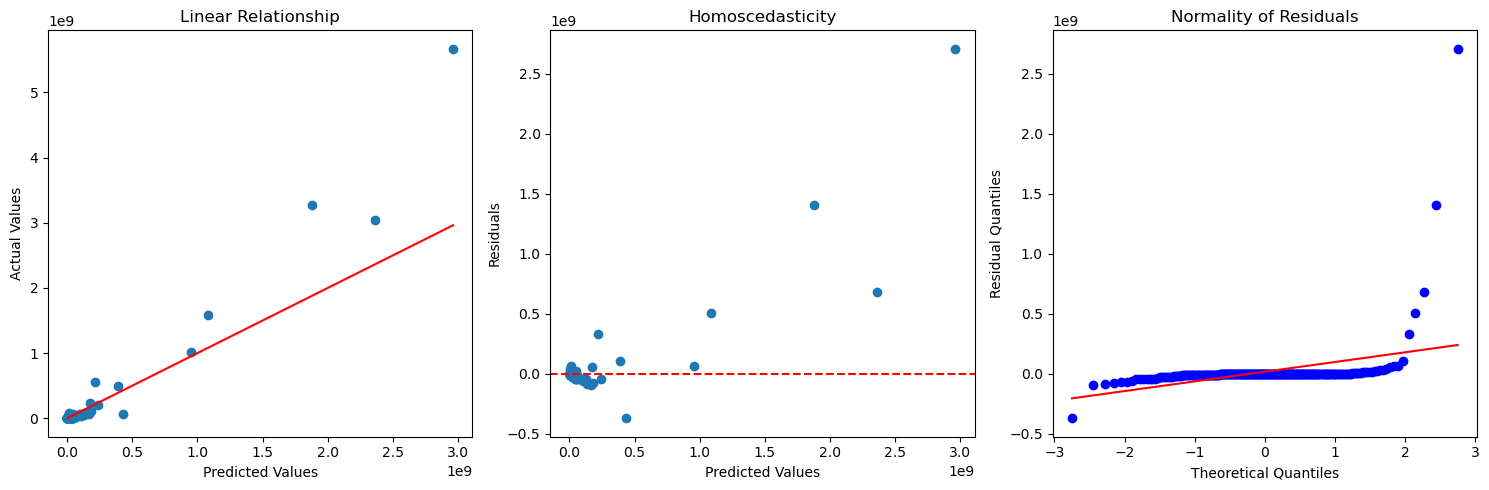

Model: RandomForestRegressor
Best Parameters: {Param(parent='RandomForestRegressor_acb874223604', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestRegressor_acb874223604', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='RandomForestRegressor_acb874223604', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='RandomForestRegressor_acb874223604', name='featureSubsetStrategy', doc="The number of features to cons

In [33]:
# To plot the Linear Relationship, Homoscedasticity and Normality of Residuals
# of the Best Performing model - Random Forest Regressor
regressor_new = [
    RandomForestRegressor(featuresCol='scaled_features', labelCol='Video_Views')
]

bestparam_values = {
    
    "RandomForestRegressor": {
        "numTrees": [200],
        "maxDepth": [5],
        "maxBins": [64]
    }
}

# To create and evaluate the model with hyperparameter tuning
for regressor in regressor_new:
    pipeline = Pipeline(stages=[scaler, regressor])
    
    param_grid = ParamGridBuilder()
    for param, values in bestparam_values[regressor.__class__.__name__].items():
        param_grid = param_grid.addGrid(getattr(regressor, param), values)
    param_grid = param_grid.build()

    # To crossvalidate the models
    evaluator = RegressionEvaluator(labelCol="Video_Views", predictionCol="prediction", metricName="rmse")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=5)

    # To run cross validation and choose best parameters
    cv_model = crossval.fit(X_train)
    best_model = cv_model.bestModel

    rf_predictions = best_model.transform(X_test)

   # To extract  actual and predicted values
    actual_values = rf_predictions.select("Video_Views")  # Assuming the column name is "Video_Views" in your DataFrame
    predicted_values = rf_predictions.select("prediction")
    
    actual_values_pd = actual_values.toPandas()
    predicted_values_pd = predicted_values.toPandas()

    # To calculate the residuals
    residuals = actual_values_pd['Video_Views'] - predicted_values_pd['prediction']


    plt.figure(figsize=(15, 5))

    # Linear Relationship
    plt.subplot(1, 3, 1)
    plt.scatter(predicted_values_pd['prediction'], actual_values_pd['Video_Views'])
    plt.plot(predicted_values_pd['prediction'], predicted_values_pd['prediction'], color='red')
    plt.title('Linear Relationship')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')

    # Homoscedasticity
    plt.subplot(1, 3, 2)
    plt.scatter(predicted_values_pd['prediction'], residuals)
    plt.axhline(0, color='red', linestyle='dashed')
    plt.title('Homoscedasticity')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')

    # Normality of Residuals
    plt.subplot(1, 3, 3)
    stats.probplot(residuals, plot=plt)
    plt.title('Normality of Residuals')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Residual Quantiles')

    plt.tight_layout()
    plt.show()
    
spark.stop()
